# Should your fund invest in Bitcoin?

## 📖 Background
You work as an analyst at an investment fund in New York. Your CFO wants to explore if it is a good idea to invest some of the fund's assets in Bitcoin. You have to prepare a report on this asset and how it compares to the stock market in general.

## 💾 The data
You have access to three files:

#### Bitcoin daily data in US dollars
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the price at the beginning of the trading day
- "high" - the highest price reached that day
- "low" - the lowest price reached that day
- "close" - the price at the closing of the trading day
- "volume" - how many Bitcoin were traded that day

#### S&P 500 daily data
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the index level at the beginning of the trading day
- "high" - the highest level reached that day
- "low" - the lowest level reached that day
- "close" - the level at the closing of the trading day
- "volume" - how many shares in the companies that make up the index were traded that day

#### inflation and gold as monthly data
- "date" - date from September, 2014 to November, 2021
- "gold_usd" - price in usd of gold for that month
- "cpi_us" - the inflation index for the US for that month (cpi = consumer price index)

_CPI data from the [U.S. Bureau of Labor Statistics](https://www.bls.gov/cpi/). Publicly available information_.

## 💪 Competition challenge
Create a report that covers the following:

1. How does the performance of Bitcoin compare to the S&P 500 and the price of gold?
2. Analyze Bitcoin's returns and volatility profile. Do you believe it could help improve the performance of a portfolio? Do you believe Bitcoin could be used as a hedge versus inflation?
3. The CFO is looking to lower volatility in the fund. Explore building a portfolio using some or all of these assets. Make a recommendation that minimizes overall risk.

Imports

In [1]:
#Data Analysis Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Time tools
import datetime
#Statistics tools
from scipy.stats import ttest_ind, ttest_1samp
#Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Setting the style
sns.set(
    font_scale=1.25
)

Looking at the data

In [3]:
#Load the csv files into pandas DataFrames
bitcoin = pd.read_csv('./data/bitcoin-usd.csv', parse_dates=['date'])
sp500 = pd.read_csv('./data/sp500.csv', parse_dates=['date'])
monthly_data = pd.read_csv('./data/monthly_data.csv', parse_dates=['date'])

In [4]:
bitcoin.head()

,date,open,high,low,close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0


In [5]:
sp500.head()

,date,open,high,low,close,volume
0,2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,3209420000
1,2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,3235340000
2,2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,4880220000
3,2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,3349670000
4,2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,3279350000


In [6]:
monthly_data.head()

,date,gold_usd,cpi_us
0,2014-09-01,1241.330,237.852
1,2014-10-01,1223.565,238.031
2,2014-11-01,1176.413,237.433
3,2014-12-01,1200.440,236.151
4,2015-01-01,1249.333,234.812


## How does Bitcoin's performance compare to that of Gold and S&P 500?

Calculate the % Growth from a given reference date

In [7]:
def get_percent_change(df, ref_date='2014-09-17'):
    #Returns a data frame with the percentage change of trading parameters relative to a reference date
    #For stock prices, the percentage change will be calculated relative to the closing price on the first day
    #For volume of trades, the percentage change will be calculated relative to the volume of trades on the first day
    
    #Stocks aren't traded on the weekend, so the reference date needs to be a weekday
    ref_date = get_next_weekday(ref_date) 
    df_change = df[df.date >= ref_date]
    #Determine the reference date
    ref_data = df_change[df_change.date == ref_date]
    #Find how much the prices changed relative to the first date
    df_change.loc[:,'open':'close'] /= float(ref_data.close)
    df_change.loc[:,'volume'] /= float(ref_data.volume)
    #Find the percentage change relative to the first date
    df_change.loc[:,'open':] = (df_change.loc[:,'open':] - 1)*100
    #Remove the first data point, since it is the reference point and thus does not give any insightful information
    return df_change.iloc[1:]

def get_next_weekday(date, date_format='%Y-%m-%d'):
    #Dates need to be passed in the format YYYY-MM-DD
    #Otherwise, another format needs to be passed
    date = datetime.datetime.strptime(date, date_format)
    #The weekday() function returns 0 for Monday and 6 for Sunday
    while date.weekday() >= 5:
        date += datetime.timedelta(days=1)
    #The format needs to be the same as the date in the data sets
    return date.strftime('%Y-%m-%d')

In [14]:
ref_date='2014-09-17'
bitcoin_percent_change = get_percent_change(bitcoin, ref_date)
sp500_percent_change = get_percent_change(sp500, ref_date)
gold_percent_change = monthly_data[["date", "gold_usd"]][monthly_data.date >= ref_date]
gold_percent_change.gold_usd = (gold_percent_change.gold_usd / float(gold_percent_change.gold_usd.iloc[0])-1)*100

Conduct a Hypothesis test to determine how Bitcoin's and Gold's growth compares to the average stock market

### Hypothesis Test: Bitcoin's growth is better than the stock market's average growth
<b>Null Hypothesis</b>: Bitcoin has the same growth as the stock market

<b>Alternative Hypothesis</b>: Bitcoin has better growth than the stock market

In [15]:
tstat, pval = ttest_1samp(bitcoin_percent_change.close.dropna(), sp500_percent_change.close.mean(), alternative="greater")
if pval < 0.05:
    print("Bitcoin has better growth than the stock market")
else:
    print("Bitcoin has the same growth as the stock market")

Bitcoin has better growth than the stock market


### Hypothesis Test: Gold's growth is better than the stock market's average growth
<b>Null Hypothesis</b>: Gold has the same growth as the stock market

<b>Alternative Hypothesis</b>: Gold has better growth than the stock market

In [16]:
tstat, pval = ttest_1samp(gold_percent_change.gold_usd.dropna(), sp500_percent_change.close.mean(), alternative="greater")
if pval < 0.05:
    print("Gold has better growth than the stock market")
else:
    print("Gold has the same growth as the stock market")

Gold has the same growth as the stock market


<b>Analysis</b>

From the above hypothesis tests, we see that Bitcoin could be a good investment opportunity, since it has better growth than the average stock market. We will need to investigate Bitcoin's performance further to make actionable investment recommendations.

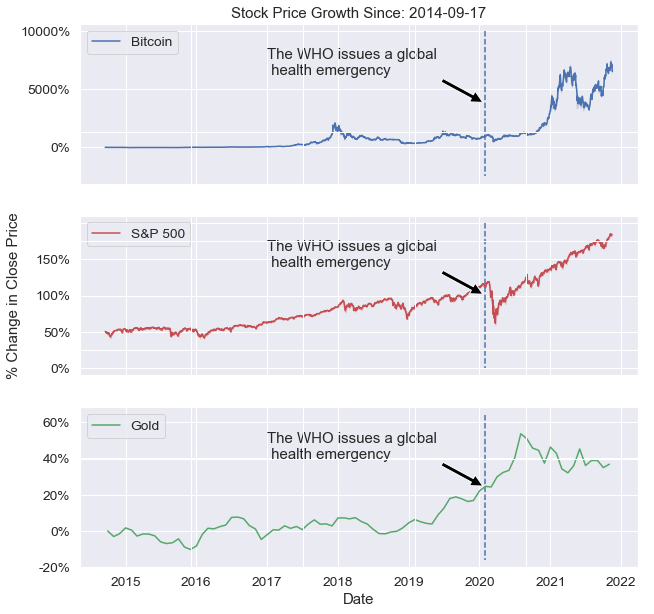

In [18]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
#Plot the bitcoin data with a fill indicating the highs and lows of each date
axs[0].plot(bitcoin_percent_change.date, bitcoin_percent_change.close, 'b-', label="Bitcoin")
axs[0].fill_between(bitcoin_percent_change.date, bitcoin_percent_change.low, bitcoin_percent_change.high, color='b', alpha=0.2)

### WE SHOULD PLOT THE LINES OF BEST FIT FOR GOLD AND S&P 500 ###

#Plot the S&P 500 data with a fill indicating the highs and lows of each date
axs[1].plot(sp500_percent_change.date, sp500_percent_change.close, 'r-', label="S&P 500")
axs[1].fill_between(sp500_percent_change.date, sp500_percent_change.low, sp500_percent_change.high, color='r', alpha=0.2)
#Plot the monthly data for the price of gold
axs[2].plot(gold_percent_change.date, gold_percent_change.gold_usd, 'g-', label="Gold")
#Format the y-axis to represent % change
for ax in axs:
    y_tick_vals = ax.get_yticks()
    ax.set_yticklabels([f"{int(y_val)}%" for y_val in y_tick_vals])
    ax.legend(loc="upper left")
    #Plot a line for when the first COVID case was confirmed in USA
    covid_date = "2020-01-31"
    ax.vlines(covid_date, max(y_tick_vals), min(y_tick_vals), linestyles="dashed")
    ax.annotate("The WHO issues a global\n health emergency", xy=(covid_date, np.mean(y_tick_vals)),
                xytext=("2017-01-01", np.percentile(y_tick_vals, 70)), arrowprops=dict(facecolor='black', shrink=0.05))
#Label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Date')
plt.ylabel('% Change in Close Price', labelpad=30)
plt.title('Stock Price Growth Since: ' + ref_date)
plt.savefig("Data Viz/Investment Growths.png")
plt.show()

From the plots above, we see that Bitcoin has grown significantly more than both S&P 500 and Gold over the past few years.
However, we can also see that Bitcoin's price has been fluctuating quite alot since 2021.
<br><br>
Another thing to note is that neither Bitcoin nor Gold were affected much by the Covid-19 stock crash. This could mean that these investement oportunities are a good hedge against global events, but more investigation into this claim is required for a definitive conclusion.

### Compare the monthly, quarterly and yearly returns

In [23]:
def get_aggregate_info(time_frame):

    # Create a dictionary containing date aggregation data
    week_days = [7]*53
    month_days = [31,28] + [31,30]*2 + [31,31] + [30,31]*2
    quarter_days = [sum(month_days[n*3:(n+1)*3]) for n in range(4)]
    agg_dict = {
        'week': {
            'num_of_days': week_days,
            'format': '%W'
        },
        'month': {
            'num_of_days': month_days,
            'format': '%m'
        },
        ## Datetime doesn't have an option for quarters, so we will need to catch this scenario and convert months to quarters
        'quarter': {
            'num_of_days': quarter_days,
            'format': '%m'
        },
        'year': {
            'num_of_days': [0]*2100, #We don't want to add any days to the datetime object
            'format': '%Y'
        }
    }
    return agg_dict[time_frame]

def aggregate_time(df, time_frame, group_labels=[]):
    ### agg_time_frame is the time frame that we would like to group and aggregate the data
    ## Allowable time frames: week, month, quarter, year
    
    #Get the aggregate information
    #Catch invalid keys
    try:
        agg_info = get_aggregate_info(time_frame)
    except KeyError:
        time_frames = ["week", "month", "quarter", "year"]
        print("This is an invalid time frame. Please select one of the following:")
        for tf in time_frames:
            print(f"- {tf}")
        return

    #Categorize the dates within the time frame
    df_agg = df.copy()
    df_agg["year"] = df.date.dt.strftime("%Y").astype(np.int64)
    df_agg["time_frame"] = df.date.dt.strftime(agg_info["format"]).astype(np.int64)
    #Convert month aggregate to quarter aggregate
    if time_frame == "quarter":
        df_agg["time_frame"] = (df_agg["time_frame"] // 4 + 1).astype(np.int64)
    #Aggregate the data
    #We add group_labels to add extra layers of grouping if needed
    df_agg = df_agg.groupby(["year", "time_frame"] + group_labels).mean().reset_index()
        
    #Calculate the new date
    df_agg["date"] = df_agg.apply(lambda row: get_datetime(row, agg_info["num_of_days"]), axis=1)

    return df_agg.drop(labels=["year", "time_frame"], axis=1) #No longer need these series

#Lambda functions
def get_datetime(row, day_conversion):
    #Initialize the date to the beginning of the year
    date_year = datetime.datetime(int(row.year), 1, 1)
    num_days = sum(day_conversion[:int(row.time_frame) - 1])  #The number of days since the begining of the year
    return date_year + datetime.timedelta(days=num_days)

Merge the data together for monthly comparisons of inflation-adjusted growth

In [24]:
#Aggregate stocks to monthly data, since we only have monthly inflation data
bc_monthly = aggregate_time(bitcoin, 'month').drop(["open", "high", "low"], axis=1)
sp_monthly = aggregate_time(sp500, 'month').drop(["open", "high", "low"], axis=1)
#Merge the data together
stocks = pd.merge(bc_monthly, sp_monthly, on="date", suffixes=("_bitcoin", "_sp500"))
stocks = pd.merge(stocks, monthly_data, on="date", suffixes=("", ""))

#Calculate the percentage change
stock_changes = stocks.drop("date", axis=1).pct_change()
stock_changes["date"] = stocks.date
stock_changes.rename(columns={"gold_usd": "close_gold", "cpi_us": "inflation"}, inplace=True)
#Unpivot the columns
stock_changes = pd.melt(stock_changes, id_vars=["inflation", "date"], value_name="growth")
#Split the stock and trade types into different columns
stock_changes[["trade_type", "stock"]] = stock_changes.variable.str.split("_", 1, expand=True)
#Remove unneeded information
stock_changes.drop("variable", axis=1, inplace=True)
stock_changes.dropna(inplace=True)
#Adjust for inflation
stock_changes.growth = (1 + stock_changes.growth) / (1 + stock_changes.inflation) - 1
#Convert to percentage change
stock_changes[["growth", "inflation"]] *= 100

stock_changes.head()

,inflation,date,growth,trade_type,stock
1,0.075257,2014-10-01,-10.635871,close,bitcoin
2,-0.251228,2014-11-01,0.788959,close,bitcoin
3,-0.539942,2014-12-01,-6.276779,close,bitcoin
4,-0.567010,2015-01-01,-26.684802,close,bitcoin
5,-0.470589,2015-02-01,-5.435185,close,bitcoin


Sepperate data into price and volume changes

In [29]:
price_changes = stock_changes[stock_changes.trade_type == "close"].drop("trade_type", axis=1)
volume_changes = stock_changes[stock_changes.trade_type == "volume"].drop("trade_type", axis=1)

### Looking at the distributions of the stock options

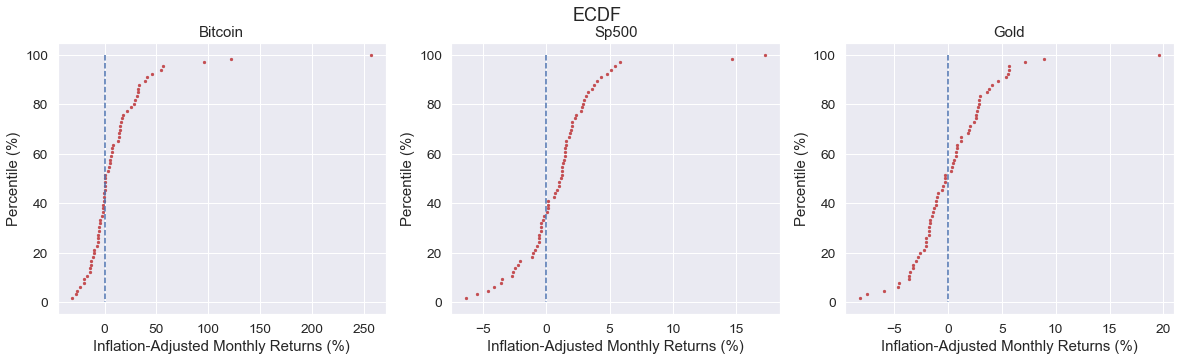

In [31]:
def ECDF(series, ax):
    #Emperical Cumulative Distribution Function
    n = len(series)
    x = np.sort(series)
    y = np.arange(1, n+1)/n * 100
    ax.scatter(x,y, c='r', s=5)
    ax.vlines(0,100,0,linestyles="dashed")
    ax.set_ylabel("Percentile (%)")
    ax.set_xlabel("Inflation-Adjusted Monthly Returns (%)")


fig, axs = plt.subplots(ncols=3, figsize=(20,5))
stocks = ["bitcoin", "sp500", "gold"]
for stock, ax in zip(stocks, axs):
    ax.set_title(stock.title())
    ECDF(price_changes[price_changes.stock == stock].growth, ax)
fig.suptitle("ECDF")
plt.savefig("Data Viz/ECDF inf-adj Growth.png")
plt.show()

The above plots are Emperical cumulative density functions (ECDFs). These plots tell us what percentile the growth is in.
A percentile indicates the percentage of values that fall bellow it. <br>For example, the plots above contain a vertical line at 0% monthly returns to seperate the monthly gains from the monthly losses. For Bitcoin, this line intersects the ECDF around the 40th percentile. This means that 40% of the monthly returns are losses. Similarly, we can see that 40% of S&P500's monthly returns are losses and 50% of Gold's monthly returns are losses

<b>Analysis</b>

The above ECDFs indicate that you are more likely to receive monthly gains when investing in Bitcoin than Gold.

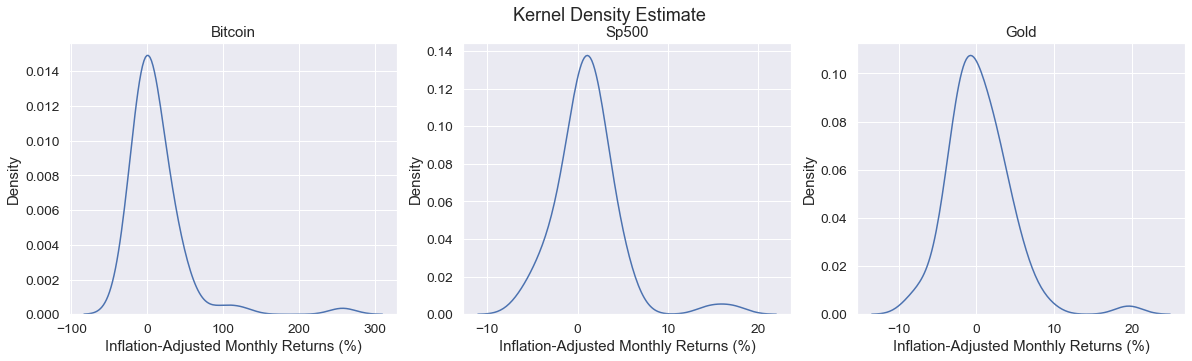

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
for stock, ax in zip(stocks, axs):
    sns.kdeplot(price_changes[price_changes.stock == stock].growth, ax=ax)
    ax.set_title(stock.title())
    ax.set_xlabel("Inflation-Adjusted Monthly Returns (%)")
fig.suptitle("Kernel Density Estimate")
plt.savefig("Data Viz/KDE inf-adj Growth.png")
plt.show()

A Kernel Density Estimate is similar to a histogram, but it is smoothed. The larger density values indicate more monthly returns at the value on the x-axis.
<br>For example, we can see that the majority of the monthly returns for all investment opportunities are at 0% gain with an approximately normal distribution. We can also notice that these distributions are slightly right-skewed, meaning that the majority of the extreme monthly changes result in gains.

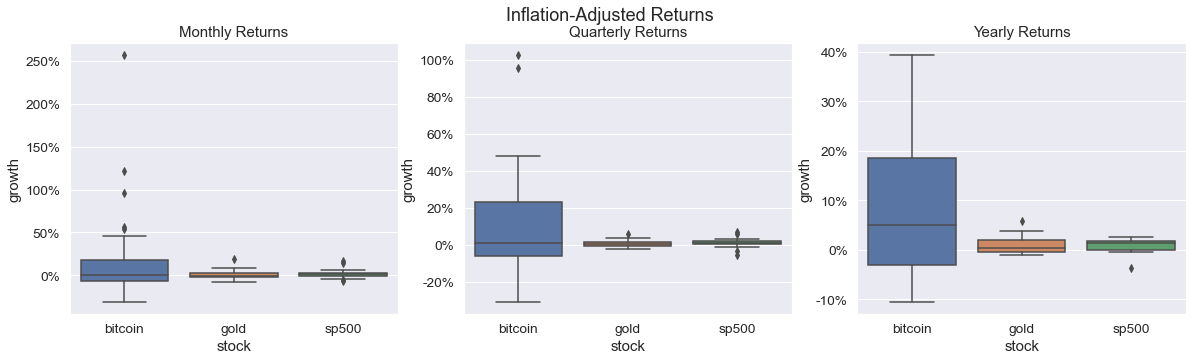

In [37]:
time_frames = ["month","quarter", "year"]
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
fig.suptitle("Inflation-Adjusted Returns")

for time_frame, ax in zip(time_frames, axs):
    #Aggregate the data
    price_changes_agg = aggregate_time(price_changes, time_frame, group_labels=["stock"])
    sns.boxplot(ax=ax, data=price_changes_agg, x="stock", y="growth")
    ax.set_title(f"{time_frame.title()}ly Returns")
    y_tick_vals = ax.get_yticks()
    ax.set_yticklabels([f"{int(y_val)}%" for y_val in y_tick_vals])
plt.savefig("Data Viz/Boxplot inf-adj Growth.png")
plt.show()

The above boxplots demonstrate that Bitcoin has a much larger range of monthly, quarterly and yearly returns than Gold and S&P500. This likely means that Bitcoin is much more volatile than Gold and S&P500, but we will analyze this in more detail in the final section. <br>We can also see that Bitcoin has extremely large positive outliers, which is a big reason that people invest in Bitcoin. We will investigate further to see if these large positive outliers are significant enough to outweigh the significant amount of large losses.

<b>Bitcoin's Growth Analysis</b>

Combining the observations in this section, we can see that investing in S&P500 is safer than Bitcoin, since we can expect steady growth in the coming months with less risk. Bitcoin's growth seems to change quite spuratically in the past year, so it is uncertain if it will maintain its monstrous upward growth. At the same time, we can see that Bitcoin is likely to continue to change durastically in the months to come (whether that be gains or losses); resulting in Bitcoin being a risky investment.

## Can Bitcoin improve the performance of a portfolio? Can it hedge against the effects of inflation?

### First, we will find the correlation between investment returns and inflation

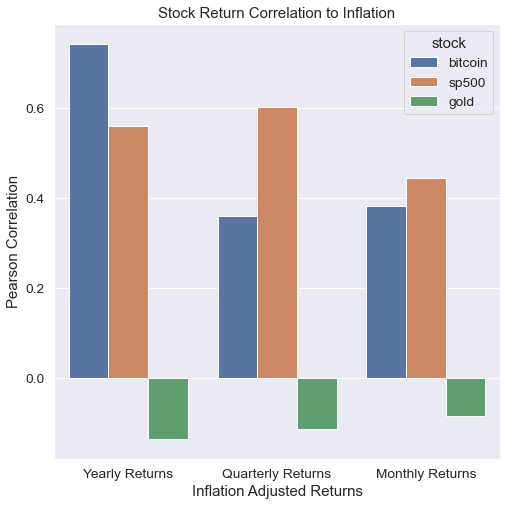

In [39]:
time_frames = ["month", "quarter", "year"]
correlations = {}
for time_frame in time_frames:
    #Aggregate the data
    price_change_agg = aggregate_time(price_changes, time_frame, group_labels=["stock"])
    #Unmelt the dataframe
    price_changes_wide = price_change_agg.pivot(index=["inflation", "date"], columns="stock").reset_index()
    #Rename columns to remove multi-indexing 
    price_changes_wide.columns = ["inflation", "date", "bitcoin", "gold", "sp500"]
    #Calculate the correlations
    correlations[f"{time_frame}ly returns".title()] = price_changes_wide.drop("date", axis=1).corr().inflation.iloc[1:]
#Convert to long-form dataframe
corr_df = pd.DataFrame(correlations).reset_index().rename(columns={"index":"stock"})
corr_df = corr_df.melt(id_vars="stock", var_name="Return Scope", value_name="Pearson Correlation")
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(data=corr_df.sort_values("Pearson Correlation", ascending=False), x="Return Scope", y="Pearson Correlation", hue="stock")
plt.title("Stock Return Correlation to Inflation")
plt.xlabel("Inflation Adjusted Returns")
plt.savefig("Data Viz/Growth-Inflation correlation.png")
plt.show()

The pearson correlation gives an indication of how much two properties move together. A correlation of +1 means a rise in one variable is likely to be correlated to a rise in the other variable. A correlation of 0 means that the rise in one variable will likely have no relation to the change in the other variable. Finally, a correlation of -1 means that the rise in one variable is likely to be correlated to a fall in the other variable.

<b>Analysis</b>

From the above barplot, we can see that gold is not strongly correlated to inflation, whereas Bitcoin and S&P 500 have strong positive correlations to inflation.<br>
This tells us that Bitcoin might be a good hedge against inflation, since Bitcoin has increasingly larger returns while inflation increases.<br>
Alternatively, Gold might be a good investment to hedge against inflation, since it's growth is fairly independant of inflation.

### Conduct a Hypothesis Test to determine if Bitcoin performs well under inflation

In [40]:
def hypothesis_test(time_frame, ref_stock, df=stock_changes):
    #Aggregate data based on time_frame
    df_agg = aggregate_time(df, time_frame, group_labels=["trade_type", "stock"])
    # Extract the price growth data for each stock
    stocks = ["bitcoin", "sp500", "gold"]
    price_growth = {
        stock: df_agg[(df_agg.trade_type == "close") & (df_agg.stock == stock)].growth for stock in stocks
    }

    #Conduct the hypothesis tests
    _, pval = ttest_ind(price_growth["bitcoin"], price_growth[ref_stock], equal_var=False, alternative="greater")
    if pval < 0.05:
        print(f"Bitcoin has better {time_frame}ly returns than {ref_stock} under inflation\n")
    else:
        print(f"Bitcoin has the same {time_frame}ly returns as {ref_stock} under inflation\n")

#### Hypothesis Test #1: Bitcoin performs better than S&P500 under inflation
<b>Null Hypothesis:</b> Bitcoin's inflation-adjusted growth is the same as S&P 500
<br><br>
<b>Alternative Hypothesis:</b> Bitcoin's inflation-adjusted growth is larger than S&P 500
<br><br>

In [41]:
time_frames = ["month", "quarter", "year"]
print(f"Bitcoin vs S&P 500")
print("===============================================================================================================================")
for time_frame in time_frames:
    hypothesis_test(time_frame, "sp500")

Bitcoin vs S&P 500
Bitcoin has better monthly returns than sp500 under inflation

Bitcoin has the same quarterly returns as sp500 under inflation

Bitcoin has the same yearly returns as sp500 under inflation



#### Hypothesis Test #2: Bitcoin performs better than Gold under inflation
Null Hypothesis:<br>
Bitcoin's inflation-adjusted growth is the same as S&P 500
<br><br>
Alternative Hypothesis:<br>
Bitcoin's inflation-adjusted growth is larger than S&P 500
<br><br>

In [36]:
time_frames = ["month", "quarter", "year"]
print(f"Bitcoin vs Gold")
print("===============================================================================================================================")
for time_frame in time_frames:
    hypothesis_test(time_frame, "gold")

Bitcoin vs Gold
Bitcoin has better monthly returns than gold under inflation

Bitcoin has better quarterly returns than gold under inflation

Bitcoin has the same yearly returns as gold under inflation



<b>Bitcoin's Hedge Against Inflation Analysis</b>

From the above hypothesis tests, we can see that Bitcoin performs better than S&P500 and Gold under monthly inflation. Furthermore, Bitcoin performs better than Gold under quarterly inflation. This second observation is especially interesting, since Gold is known to be a good hedge against inflation. 
<br><br>However, Bitcoin performs similarly to Gold and S&P500 under annual inflation, so it might not be a good long term solution for hedging against inflation, especially since we discovered earlier that Bitcoin's annual performance is strongly correlated to inflation.
<br><br>All in all, Bitcoin could be a good solution for inflation in the short term as long as its profile isn't too volatile, since high volatility is unfavorable when investing in the short-term.

## Bitcoin's Volatility

### Calculate the average true range over a 14 day period

In [42]:
bitcoin["pct_ATR_14_day"] = (bitcoin.high - bitcoin.low).pct_change(14)/14 * 100
sp500["pct_ATR_14_day"] = (sp500.high - sp500.low).pct_change(14)/14 * 100

### Hypothesis Test: Bitcoin is more volatile than the stock market
<b>Null Hypothesis:</b> Bitcoin has the same Average True Range (ATR) as the stock market over a 14 day period
<b>Alternative Hypothesis:</b> Bitcoin has a larger Average True Range (ATR) as the stock market over a 14 day period

In [43]:
tstat, pval = ttest_ind(bitcoin.pct_ATR_14_day.dropna(), sp500.pct_ATR_14_day.dropna())
if pval < 0.05:
    print("Bitcoin is more volatile than the stock market")
else:
    print("Bitcoin is as volatile as the stock market")

Bitcoin is more volatile than the stock market


<b>Bitcoin's Volatility Analysis</b>
From the above hypothesis test, we can see that Bitcoin is more volatile than the stock market. As such, it is probably 

## Summary of Findings

#### 1. How does Bitcoin's performance compare to the stock market and the price of gold?
<ul>
    <li>
        First, we conducted a hypothesis test that demonstrated that the growth of Bitcoin and Gold are statistically better than the average stock market growth<br><br>
    </li>
    <li>
        The plot bellow demonstrates that Bitcoin had far greater growth with much greater fluctuation since 2021.<br>The plot also demonstrates that Bitcoin and Gold were not impacted much by the COVID stock crash (as outlined by the dashed line), although Gold's price growth may have stagnated as a result of the pandemic.<br>
        <br><img src="Data Viz/Investment Growths.png"><br>
    </li>
    <li>
        The Emperical Cumulative Distribution Function (ECDF) below demonstrates that Bitcoin and the stock market have monthly growths that are mostly positive (around 60% of their growths are positive).<br>Alternatively, Gold has approximately half of its monthly growths in the negative.<br>
        <br><img src="Data Viz/ECDF inf-adj Growth.png"><br>
    </li>
    <li>
        The Kernel Density Estimate (KDE) plots below demonstrate that the monthly inflation-adjusted returns of all the investment opportunities are approximately normal distributions with a mean around 0% growth (with the stock market having a slightly positive mean and gold having a slightly negative mean)<br>We can also notice that Bitcoin has a slightly more right-skewed distribution, meaning that it is more likely to have larger monthly returns than Gold and the stock market<br>
        <br><img src="Data Viz/KDE inf-adj Growth.png"><br>
    </li>
    <li>
        The boxplot below demonstrates that Bitcoin's monthly returns have a much larger spread than the stock market and gold, with much larger positive outliers.<br>
        <br><img src="Data Viz/Boxplot inf-adj Growth.png"><br>
    </li>
</ul>
<br><br>

#### 2. Can Bitcoin hedge against the effects of inflation?

<ul>
    <li>
        The barplot below demonstrates the pearson correlation between the investment growths and inflation.<br> <br>We can see that the growth of Bitcoin and the stock market are highly positively correlated to inflation, whereas Gold is not correlated much to inflation.<br>
        <br><br><img src="Data Viz/Growth-Inflation correlation.png"><br>
    </li>
    <li>
        Next, we conducted a hypothesis test that demonstrated that Bitcoin is better than gold at hedging against inflation on a monthly and quarterly time frame.
    </li>
    <li>
        Finally, we conducted a hypothesis test that demonstrated that Bitcoin is more volatile than the stock market.<br>As such, it is hard to say if Bitcoin would be a good hedge against inflation on a short time frame, since its high volatility suggests that one should invest in Bitcoin for the long-term.
    </li>
</ul>


## Portfolio Recommendations

Although Bitcoin has alot of potential for future growth, I would have to recommend to not include it as an investment in the fund. It could be used as a short-term solution to inflation, however its high volatility and strong correlation to inflation makes it a risky investment for the fund.<br><br>I believe that gold would make a better hedge against inflation, since it has steady growth and has little to no correlation with inflation. Furthermore, gold doesn't seem to have been impacted by the effects of COVID-19, so it might also be a good hedge against global issues; this, however, would need to be investigated further for a more conclusive assessment.